# Importing the packages and data

In [1]:
%load_ext autoreload
%autoreload 2

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.special import gamma, digamma, polygamma
import math

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import random

import scipy.optimize
from scipy.optimize import Bounds
from scipy import sparse

from scipy.stats import ttest_ind

In [3]:
from prettytable import PrettyTable

In [4]:
plt.rcParams.update({
    "text.usetex": True
})

In [5]:
import dirichlet_regression

In [48]:
from scipy.optimize import fmin, newton, minimize, minimize_scalar, brute

In [7]:
def f_spatial(x, X, Y, Z, W, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    n = X.shape[0]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:-1]
    rho = x[-1]
    Minv = np.linalg.inv(np.identity(n) - rho*W)
    mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho=rho, W=W, Minv=Minv)
    phi = np.exp(np.matmul(Z,gamma_var))
    return -dirichlet_regression.dirichlet_loglikelihood(mu,phi,Y,epsilon=epsilon)

In [8]:
def fprime_spatial(x, X, Y, Z, W, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    n = X.shape[0]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:-1]
    rho = x[-1]
    Minv = np.linalg.inv(np.identity(n) - rho*W)
    MinvX = np.matmul(Minv,X)
    mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho=rho, W=W, MinvX=MinvX)
    phi = np.exp(np.matmul(Z,gamma_var))

    beta_grad = dirichlet_regression.dirichlet_gradient_wrt_beta(mu, phi, MinvX, Y, epsilon=epsilon)
    beta_grad[:,0] = 0
    gamma_grad = dirichlet_regression.dirichlet_derivative_wrt_gamma(mu, phi, beta, MinvX, Y, Z, epsilon=epsilon)
    rho_derivative = dirichlet_regression.dirichlet_derivative_wrt_rho(mu, phi, Minv, beta, W, X, Y, Z, MinvX, epsilon=epsilon)
    return(-np.concatenate([beta_grad.flatten(),gamma_grad,[rho_derivative]]))

In [77]:
def f_rho(rho, X, Y, Z, W, beta_gamma, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    n = X.shape[0]
    beta = beta_gamma[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = beta_gamma[K*J:]
    Minv = np.linalg.inv(np.identity(n) - rho*W)
    #Minv = sparse.linalg.inv(sparse.csc_matrix(np.identity(n) - rho*W)).toarray()
    #Minv = sparse.linalg.inv(sparse.csc_matrix(np.identity(n) - rho*W)).toarray()
    mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho=rho, W=W, Minv=Minv)
    phi = np.exp(np.matmul(Z,gamma_var))
    return -dirichlet_regression.dirichlet_loglikelihood(mu,phi,Y,epsilon=epsilon)

def fprime_rho(rho, X, Y, Z, W, beta_gamma, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    n = X.shape[0]
    beta = beta_gamma[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = beta_gamma[K*J:]
    Minv = np.linalg.inv(np.identity(n) - rho*W)
    MinvX = np.matmul(Minv,X)
    mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho=rho, W=W, MinvX=MinvX)
    phi = np.exp(np.matmul(Z,gamma_var))

    rho_derivative = dirichlet_regression.dirichlet_derivative_wrt_rho(mu, phi, Minv, beta, W, X, Y, Z, MinvX, epsilon=epsilon)
    return(rho_derivative)

In [78]:
%%time
solution_rho = minimize_scalar(f_rho, method='bounded', bounds=(-1,1), args=(X, Y, Z, W, solution_beta_gamma.x))
solution_rho

Wall time: 661 ms


     fun: -2830.6136560882915
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.21235592892617036

In [10]:
def f_beta_gamma(beta_gamma, X, Y, Z, W, rho, Minv, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    n = X.shape[0]
    beta = beta_gamma[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = beta_gamma[K*J:]
    mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho=rho, W=W, Minv=Minv)
    phi = np.exp(np.matmul(Z,gamma_var))
    return -dirichlet_regression.dirichlet_loglikelihood(mu,phi,Y,epsilon=epsilon)

def fprime_beta_gamma(beta_gamma, X, Y, Z, W, rho, Minv, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    n = X.shape[0]
    beta = beta_gamma[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = beta_gamma[K*J:]
    
    MinvX = np.matmul(Minv,X)
    
    mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho=rho, W=W, MinvX=MinvX)
    phi = np.exp(np.matmul(Z,gamma_var))

    beta_grad = dirichlet_regression.dirichlet_gradient_wrt_beta(mu, phi, MinvX, Y, epsilon=epsilon)
    beta_grad[:,0] = 0
    gamma_grad = dirichlet_regression.dirichlet_derivative_wrt_gamma(mu, phi, beta, MinvX, Y, Z, epsilon=epsilon)
    return(-np.concatenate([beta_grad.flatten(),gamma_grad,]))

In [11]:
def f_no_spatial(x, X, Y, Z, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:]
    mu = dirichlet_regression.compute_mu_3(X, beta)
    phi = np.exp(np.matmul(Z,gamma_var))
    return -dirichlet_regression.dirichlet_loglikelihood(mu,phi,Y,epsilon=epsilon)

In [12]:
def fprime_no_spatial(x, X, Y, Z, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:]
    mu = dirichlet_regression.compute_mu_3(X, beta)
    phi = np.exp(np.matmul(Z,gamma_var))
    beta_grad = dirichlet_regression.dirichlet_gradient_wrt_beta(mu, phi, X, Y, epsilon=epsilon)
    beta_grad[:,0] = 0
    gamma_grad = dirichlet_regression.dirichlet_derivative_wrt_gamma(mu, phi, beta, X, Y, Z, epsilon=epsilon)
    return(-np.concatenate([beta_grad.flatten(),gamma_grad]))

In [13]:
def create_features_matrices(n_samples,n_features,choice_W='X_dependent',threshold_neighbors=0.3,nneighbors=5):
    X = np.random.uniform(size=(n_samples,n_features))
    X = (X-X.min())/(X.max()-X.min())
    X = np.array([np.concatenate(([1],x)) for x in X])
    Z = np.random.uniform(size=(n_samples,n_features))
    
    if choice_W == 'random':
        neighbors = NearestNeighbors(n_neighbors=nneighbors).fit(np.arange(n_samples).reshape(-1,1))
        W = neighbors.kneighbors_graph(np.arange(n_samples).reshape(-1,1)).toarray()
    else:
        distance_matrix = scipy.spatial.distance_matrix(X,X)
        W = np.zeros(np.shape(distance_matrix))
        W[distance_matrix < threshold_neighbors] = 1
    # replace the 1 on the diagonal by 0
    np.fill_diagonal(W,0)
    # scaling the matrix, so that the sum of each row is 1
    W = W/W.sum(axis=1)[:,None]
    return(X,Z,W)

# With two features

In [14]:
n_features = 2
n_classes = 3

In [15]:
np.random.seed(21)

beta = np.array([[0.  , -1.6 , 1.],
                 [0.  , 1.8, -1.4],
                 [0.  , 1.4, -1.1 ]])

gamma_var = np.round(np.random.normal(size=(n_features)),2)

In [16]:
beta0 = np.zeros((n_features+1,n_classes))
gamma0 = [0.,0.]
rho0 = [0.]
params0_spatial = np.concatenate([beta0.flatten(),gamma0, rho0])
params0_beta_gamma = np.concatenate([beta0.flatten(),gamma0])
params0_no_spatial = np.concatenate([beta0.flatten(),gamma0])

In [17]:
X,Z,W = create_features_matrices(50,n_features,threshold_neighbors=0.3)
non_zeros_W = np.array([len(W[i][W[i]>0]) for i in range(len(W))])
np.mean(non_zeros_W)

10.72

In [18]:
X,Z,W = create_features_matrices(200,n_features,threshold_neighbors=0.14)
non_zeros_W = np.array([len(W[i][W[i]>0]) for i in range(len(W))])
np.mean(non_zeros_W)

9.95

In [19]:
X,Z,W = create_features_matrices(500,n_features,threshold_neighbors=0.09)
non_zeros_W = np.array([len(W[i][W[i]>0]) for i in range(len(W))])
np.mean(non_zeros_W)

11.796

In [20]:
X,Z,W = create_features_matrices(1000,n_features,threshold_neighbors=0.06)
non_zeros_W = np.array([len(W[i][W[i]>0]) for i in range(len(W))])
np.mean(non_zeros_W)

10.816

In [21]:
n_samples = 1000

In [22]:
X,Z,W = create_features_matrices(1000,n_features,choice_W='random',nneighbors=6)

## rho=0.5

In [23]:
rho = 0.5

In [24]:
mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho, W)
phi = np.exp(np.matmul(Z,gamma_var))
alpha = mu*phi[:,None]

Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
Y = (Y*(n_samples-1)+1/n_classes)/n_samples

In [69]:
%%time
solution_beta_gamma = minimize(f_beta_gamma, params0_beta_gamma, args=(X, Y, Z, W, 0, np.identity(n_samples)), jac=fprime_beta_gamma)

Wall time: 1.19 s


In [70]:
solution_beta_gamma.x

array([ 0.        , -1.16734244,  0.28968016,  0.        ,  1.32133291,
       -0.83133867,  0.        ,  1.19714476, -0.34104312,  0.14639614,
        0.04472951])

In [27]:
solution_no_spatial = minimize(f_no_spatial, params0_no_spatial, args=(X, Y, Z), jac=fprime_no_spatial)

In [28]:
solution_no_spatial.x

array([ 0.        , -1.16734244,  0.28968016,  0.        ,  1.32133291,
       -0.83133867,  0.        ,  1.19714476, -0.34104312,  0.14639614,
        0.04472951])

In [31]:
%%time
solution_rho = minimize(f_rho, 0., args=(X, Y, Z, W, solution_beta_gamma.x), jac=fprime_rho)

Wall time: 15.3 s


In [32]:
solution_rho

      fun: -2823.7089220979146
 hess_inv: array([[1]])
      jac: 53.53374719178826
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 105
      nit: 0
     njev: 93
   status: 2
  success: False
        x: array([0.])

In [74]:
%%time
solution_rho = minimize_scalar(f_rho, method='bounded', bounds=(-1,1), args=(X, Y, Z, W, solution_beta_gamma.x))
solution_rho

Wall time: 2.73 s


     fun: -2830.613656088296
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.2123559289255125

In [63]:
slice(-1,1,0.5)

slice(-1, 1, 0.5)

In [67]:
%%time
solution_rho = brute(f_rho, ranges=(slice(0.45,0.55,0.1),), args=(X, Y, Z, W, solution_beta_gamma.x))
solution_rho

Wall time: 1.44 s


array([0.52529297])

In [34]:
rho_sol = newton(fprime_rho, 0., args=(X, Y, Z, W, solution_beta_gamma.x))
rho_sol

0.21235609927292057

In [82]:
%%time
old_beta_gamma = np.copy(solution_beta_gamma.x)
Minv_sol = np.linalg.inv(np.identity(n_samples)-rho_sol*W)
solution_beta_gamma = minimize(f_beta_gamma, old_beta_gamma, args=(X, Y, Z, W, rho_sol, Minv_sol), jac=fprime_beta_gamma)

Wall time: 279 ms


In [83]:
old_beta_gamma

array([ 0.        , -1.21220098,  1.17319607,  0.        ,  1.68385711,
       -1.50337374,  0.        ,  1.31060664, -0.93667912,  0.23808544,
        0.35449693])

In [84]:
solution_beta_gamma.x

array([ 0.        , -1.2060892 ,  1.16744735,  0.        ,  1.67523745,
       -1.49599179,  0.        ,  1.30404769, -0.93208171,  0.23814742,
        0.35448731])

In [85]:
%%time
old_rho = rho_sol
rho_sol = newton(fprime_rho, old_rho, args=(X, Y, Z, W, solution_beta_gamma.x))
print(old_rho)
print(rho_sol)

0.04290346060807629
0.04784386274371686
Wall time: 362 ms


In [38]:
min_bounds_1 = -np.inf*np.ones(len(params0_spatial)) 
max_bounds_1 = np.inf*np.ones(len(params0_spatial))
min_bounds_1[-1] = -1
max_bounds_1[-1] = 1
bounds_1 = Bounds(min_bounds_1, max_bounds_1)

In [39]:
%%time
solution_spatial = minimize(f_spatial, params0_spatial, args=(X, Y, Z, W), bounds=bounds_1, jac=fprime_spatial)

Wall time: 7.45 s


In [43]:
solution_spatial

      fun: -2846.371205044604
 hess_inv: <12x12 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00000000e+00,  1.29106181e-02, -1.60514057e-02, -0.00000000e+00,
        8.62148683e-03, -1.46739590e-02, -0.00000000e+00,  7.18630871e-03,
       -9.00508848e-03,  7.22919838e-05, -9.23923474e-03,  1.82124845e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 39
      nit: 33
   status: 0
  success: True
        x: array([ 0.        , -1.14553015,  0.46076823,  0.        ,  1.27058944,
       -0.78968772,  0.        ,  1.09026092, -0.39105372,  0.16138138,
        0.06964081,  0.53278041])

In [47]:
%%time
nitermax = 50
tol = 0.005
i=0
eps = 1

old_rho = 0.2
rho_sol = 0.2
old_beta_gamma = np.copy(params0_beta_gamma)
beta_gamma_sol = np.copy(params0_beta_gamma)

while ((i<nitermax) & (eps>tol)):
    # update beta and gamma
    Minv_sol = np.linalg.inv(np.identity(n_samples)-rho_sol*W)
    solution_beta_gamma = minimize(f_beta_gamma, old_beta_gamma, args=(X, Y, Z, W, rho_sol, Minv_sol), jac=fprime_beta_gamma)
    
    # update rho
    rho_sol = minimize_scalar(f_rho, method='bounded', bounds=(-1,1), args=(X, Y, Z, W, solution_beta_gamma.x)).x
    #rho_sol = newton(fprime_rho, old_rho, args=(X, Y, Z, W, solution_beta_gamma.x))
    
    i+=1
    eps = abs(rho_sol - old_rho)
    
    old_beta_gamma = np.copy(solution_beta_gamma.x)
    old_rho = rho_sol

Wall time: 22.9 s


In [41]:
i

7

In [42]:
rho_sol

0.5210308665626138

In [291]:
solution_beta_gamma.x

array([ 0.        , -1.14683367,  0.46068279,  0.        ,  1.27210611,
       -0.79057201,  0.        ,  1.09179088, -0.39118423,  0.16136555,
        0.06965193])

In [292]:
solution_no_spatial.x

array([ 0.        , -1.16734244,  0.28968016,  0.        ,  1.32133291,
       -0.83133867,  0.        ,  1.19714476, -0.34104312,  0.14639614,
        0.04472951])

In [296]:
np.concatenate([beta.flatten(),gamma_var])

array([ 0.  , -1.6 ,  1.  ,  0.  ,  1.8 , -1.4 ,  0.  ,  1.4 , -1.1 ,
       -0.05, -0.11])

In [144]:
mu_sol_s = dirichlet_regression.compute_mu_spatial_2(X, solution_beta_gamma.x[:9].reshape((3,3)), rho_sol, W)

In [145]:
phi_sol_s = np.exp(np.matmul(Z,solution_beta_gamma.x[9:]))

In [146]:
dirichlet_regression.dirichlet_loglikelihood(mu_sol_s,phi_sol_s,Y,epsilon=0)

589.5147442521392

In [111]:
sol_ns = minimize(f_no_spatial, params0_no_spatial, args=(X, Y, Z), jac=fprime_no_spatial).x
sol_ns

array([ 0.        , -1.25820258,  1.21639916,  0.        ,  1.74875456,
       -1.55884955,  0.        ,  1.35996057, -0.97124012,  0.23760875,
        0.35456677])

In [122]:
mu_sol_ns = dirichlet_regression.compute_mu_2(X, sol_ns[:9].reshape((3,3)))
phi_sol_ns = np.exp(np.matmul(Z,sol_ns[9:]))

In [123]:
dirichlet_regression.dirichlet_loglikelihood(mu_sol_ns,phi_sol_ns,Y,epsilon=0)

589.2055343009955

In [124]:
mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho, W)
phi = np.exp(np.matmul(Z,gamma_var))

In [125]:
dirichlet_regression.dirichlet_loglikelihood(mu,phi,Y,epsilon=0)

463.1111727948445

In [257]:
list_ll = []
list_rhos = np.arange(-1,1,0.1)
for r in list_rhos :
    list_ll.append(-f_rho(r, X, Y, Z, W, np.concatenate([beta.flatten(),gamma_var]), epsilon=0))

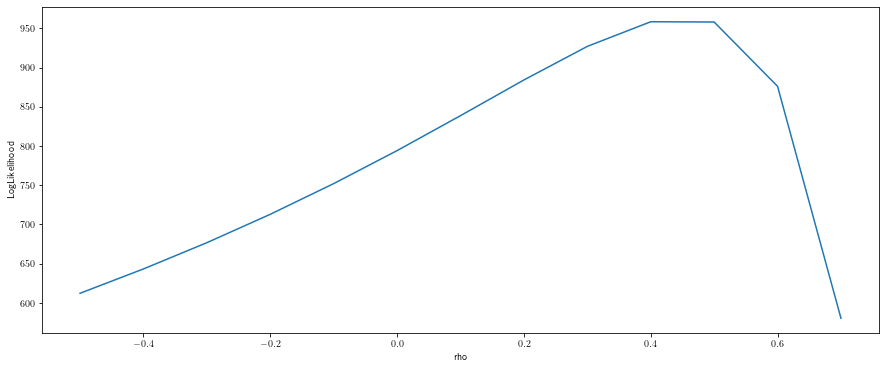

In [258]:
plt.figure(figsize=(15,6))
plt.plot(list_rhos[5:-2],list_ll[5:-2])
plt.xlabel('rho')
plt.ylabel('LogLikelihood')
plt.show()

In [259]:
minimize_scalar(f_rho, method='bounded', bounds=(-1,1), args=(X, Y, Z, W, np.concatenate([beta.flatten(),gamma_var])))

     fun: -964.2043248032605
 message: 'Solution found.'
    nfev: 13
  status: 0
 success: True
       x: 0.45320858914508994

In [286]:
rho_sol = minimize_scalar(f_rho, method='bounded', bounds=(-1,1), args=(X, Y, Z, W, solution_no_spatial.x))
rho_sol

     fun: -2830.6136560882915
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.21235592892617036

In [281]:
solution_beta_gamma = minimize(f_beta_gamma, params0_beta_gamma, args=(X, Y, Z, W, rho_sol.x, np.linalg.inv(np.identity(n_samples)-rho_sol.x*W)), jac=fprime_beta_gamma)

In [283]:
solution_beta_gamma.x

array([ 0.        , -1.21022269,  0.38182337,  0.        ,  1.35613438,
       -0.84874532,  0.        ,  1.20428414, -0.37234588,  0.15466093,
        0.05624792])

In [287]:
rho_sol = minimize_scalar(f_rho, method='bounded', bounds=(-1,1), args=(X, Y, Z, W, solution_beta_gamma.x))
rho_sol

     fun: -2838.9244258637855
 message: 'Solution found.'
    nfev: 14
  status: 0
 success: True
       x: 0.341003165047312

# Less features and classes to try to understand

In [246]:
n_features = 1
n_classes = 2

np.random.seed(1)

beta = np.array([[0.  , -1.6],
                 [0.  , 1.8]])

gamma_var = np.round(np.random.normal(size=(n_features)),2)

beta0 = np.zeros((n_features+1,n_classes))
gamma0 = [0.,0.]
rho0 = [0.]
params0_beta_gamma = np.concatenate([beta0.flatten(),gamma0])
params0_no_spatial = np.concatenate([beta0.flatten(),gamma0])

n_samples = 200

In [247]:
X,Z,W = create_features_matrices(200,n_features,threshold_neighbors=0.14,choice_W='random',nneighbors=6)
non_zeros_W = np.array([len(W[i][W[i]>0]) for i in range(len(W))])
np.mean(non_zeros_W)

5.0

In [248]:
rho = 0.5

mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho, W)
phi = np.exp(np.matmul(Z,gamma_var))
alpha = mu*phi[:,None]

Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
Y = (Y*(n_samples-1)+1/n_classes)/n_samples

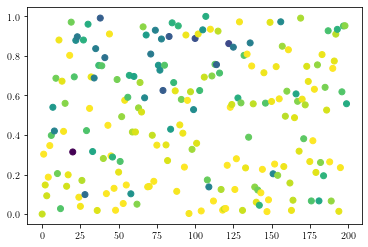

In [250]:
plt.scatter(np.arange(200),X[:,1],c=Y[:,0])
plt.show()

In [251]:
list_ll = []
list_rhos = np.arange(-1,1,0.1)
for r in list_rhos :
    list_ll.append(-f_rho(r, X, Y, Z, W, np.concatenate([beta.flatten(),gamma_var]), epsilon=0))

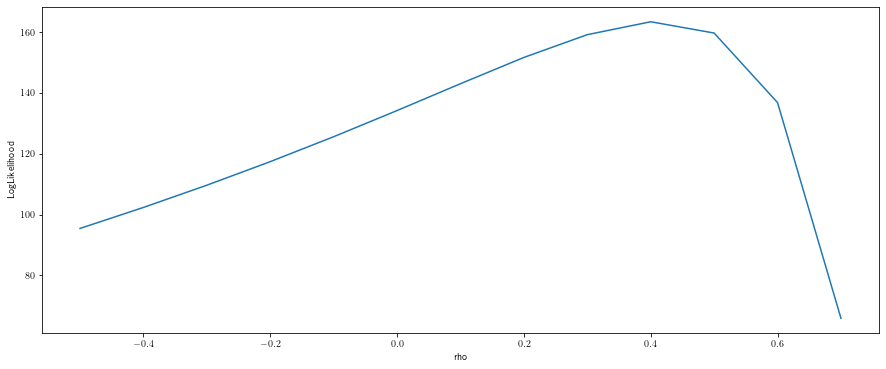

In [252]:
plt.figure(figsize=(15,6))
plt.plot(list_rhos[5:-2],list_ll[5:-2])
plt.xlabel('rho')
plt.ylabel('LogLikelihood')
plt.show()

In [ ]:
%%tim

-----
# rho = 0.5

In [100]:
%%time
n_repeat = 100

list_solutions_spatial = []
list_solutions_no_spatial = []

list_n_samples = [200,1000]
list_threshold_neighb = [0.14,0.06]

seed=0

for i in range(2):
    n_samples = list_n_samples[i]
    threshold_neighb = list_threshold_neighb[i]
    true_params = np.concatenate([beta.flatten(),gamma_var, [rho]])
    
    solutions_spatial_temp = []
    solutions_no_spatial_temp = []
    for _ in range(n_repeat):
        np.random.seed(seed)
        
        X,Z,W = create_features_matrices(n_samples,n_features,threshold_neighbors=threshold_neighb)
        try:
            mu = dirichlet_regression.compute_mu_spatial(X, beta, rho, W)
            phi = np.exp(np.matmul(Z,gamma_var))
            alpha = mu*phi[:,None]

            Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
            Y = (Y*(n_samples-1)+1/n_classes)/n_samples

            solution_spatial = minimize(f_spatial, params0_spatial, args=(X, Y, Z, W), bounds=bounds_1, jac=fprime_spatial)
            solutions_spatial_temp.append(solution_spatial.x)

            solution_no_spatial = minimize(f_no_spatial, params0_no_spatial, args=(X, Y, Z), jac=fprime_no_spatial)
            solutions_no_spatial_temp.append(solution_no_spatial.x)
        except RuntimeError:
            print("Factor is exactly singular")
        except np.linalg.LinAlgError:
            print("Singular matrix")
        
        seed+=1
    list_solutions_spatial.append(solutions_spatial_temp)
    list_solutions_no_spatial.append(solutions_no_spatial_temp)
    

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

Factor is exactly singular
Factor is exactly singular
Factor is exactly singular
Factor is exactly singular
Factor is exactly singular
Factor is exactly singular


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

Factor is exactly singular
Factor is exactly singular
Factor is exactly singular


<ipython-input-20-f0c0c0a7e579>:17: RuntimeWarning: invalid value encountered in true_divide
  W = W/W.sum(axis=1)[:,None]


Factor is exactly singular


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,Non

Factor is exactly singular


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,Non

Factor is exactly singular
Singular matrix


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

Singular matrix


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

Singular matrix


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

Singular matrix
Factor is exactly singular


<ipython-input-20-f0c0c0a7e579>:17: RuntimeWarning: invalid value encountered in true_divide
  W = W/W.sum(axis=1)[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
 

Factor is exactly singular
Factor is exactly singular


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

Wall time: 37min 18s


In [101]:
temp_spatial_200 = np.array(list_solutions_spatial[0])
temp_spatial_1000 = np.array(list_solutions_spatial[1])

temp_no_spatial_200 = np.array(list_solutions_no_spatial[0])
temp_no_spatial_1000 = np.array(list_solutions_no_spatial[1])

In [105]:
list_solutions_spatial[1] = temp_spatial_200
list_solutions_spatial[2] = temp_spatial_1000

list_solutions_no_spatial[1] = temp_no_spatial_200
list_solutions_no_spatial[2] = temp_no_spatial_1000

In [102]:
np.mean(np.array(list_solutions_spatial[0])[:,-1])

0.5410796428674394

In [103]:
np.mean(np.array(list_solutions_spatial[1])[:,-1])

0.6146562712605864

In [106]:
np.save('Data Dirichlet/spatial_rho05.npy',list_solutions_spatial)

In [107]:
np.save('Data Dirichlet/no_spatial_rho05.npy',list_solutions_no_spatial)

In [104]:
list_solutions_spatial = np.load('Data Dirichlet/spatial_rho05.npy',allow_pickle=True)
list_solutions_no_spatial = np.load('Data Dirichlet/no_spatial_rho05.npy',allow_pickle=True)

In [108]:
%%time
n_repeat = 100

size_test = 1000

list_n_samples = [50,200,1000]

list_r2_s = []
list_rmse_s = []
list_ll_s = []
list_crossentropy_s = []
list_r2_ns = []
list_rmse_ns = []
list_ll_ns = []
list_crossentropy_ns = []

seed=0

true_params = np.concatenate([beta.flatten(),gamma_var, [rho]])

for n_samples_index in range(3):
    list_r2_s_temp = []
    list_rmse_s_temp = []
    list_ll_s_temp = []
    list_crossentropy_s_temp = []
    list_r2_ns_temp = []
    list_rmse_ns_temp = []
    list_ll_ns_temp = []
    list_crossentropy_ns_temp = []
    for i in range(len(list_solutions_spatial[n_samples_index])):
        np.random.seed(seed+1000)
        
        X,Z,W = create_features_matrices(size_test,n_features)
        try:
            mu = dirichlet_regression.compute_mu_spatial(X, beta, rho, W)
            phi = np.exp(np.matmul(Z,gamma_var))
            alpha = mu*phi[:,None]

            Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
            Y = (Y*(size_test-1)+1/n_classes)/size_test

            solution_spatial = list_solutions_spatial[n_samples_index][i]
            beta_sol_s = solution_spatial[:(n_features+1)*n_classes].reshape((n_features+1),n_classes)
            gamma_sol_s = solution_spatial[(n_features+1)*n_classes:-1]
            rho_sol_s = solution_spatial[-1]
            mu_sol_s = dirichlet_regression.compute_mu_spatial_2(X, beta_sol_s, rho_sol_s, W)
            phi_s = np.exp(np.matmul(Z,gamma_sol_s))
            
            list_r2_s_temp.append(r2_score(Y,mu_sol_s))
            list_rmse_s_temp.append(mean_squared_error(Y,mu_sol_s,squared=False))
            list_ll_s_temp.append(dirichlet_regression.dirichlet_loglikelihood(mu_sol_s,phi_s,Y))
            list_crossentropy_s_temp.append(-(1/size_test)*np.sum(Y*np.log(mu_sol_s)))
            
            solution_no_spatial = list_solutions_no_spatial[n_samples_index][i]
            beta_sol_ns = solution_no_spatial[:(n_features+1)*n_classes].reshape((n_features+1),n_classes)
            gamma_sol_ns = solution_no_spatial[(n_features+1)*n_classes:]
            mu_sol_ns = dirichlet_regression.compute_mu_3(X, beta_sol_ns)
            phi_ns = np.exp(np.matmul(Z,gamma_sol_ns))
            
            list_r2_ns_temp.append(r2_score(Y,mu_sol_ns))
            list_rmse_ns_temp.append(mean_squared_error(Y,mu_sol_ns,squared=False))
            list_ll_ns_temp.append(dirichlet_regression.dirichlet_loglikelihood(mu_sol_ns,phi_ns,Y))
            list_crossentropy_ns_temp.append(-(1/size_test)*np.sum(Y*np.log(mu_sol_ns)))
            
            
        except RuntimeError:
            print("Factor is exactly singular")
        except np.linalg.LinAlgError:
            print("Singular matrix")
        
        seed+=1
    list_r2_s.append(list_r2_s_temp)
    list_rmse_s.append(list_rmse_s_temp)
    list_ll_s.append(list_ll_s_temp)
    list_crossentropy_s.append(list_crossentropy_s_temp)
    list_r2_ns.append(list_r2_ns_temp)
    list_rmse_ns.append(list_rmse_ns_temp)
    list_ll_ns.append(list_ll_ns_temp)
    list_crossentropy_ns.append(list_crossentropy_ns_temp)

Wall time: 4min 57s


In [116]:
np.save('Data Dirichlet/list_r2_s_rho05.npy', list_r2_s)
np.save('Data Dirichlet/list_rmse_s_rho05.npy', list_rmse_s)
np.save('Data Dirichlet/list_ll_s_rho05.npy', list_ll_s)
np.save('Data Dirichlet/list_crossentropy_s_rho05.npy', list_crossentropy_s)
np.save('Data Dirichlet/list_r2_ns_rho05.npy', list_r2_ns)
np.save('Data Dirichlet/list_rmse_ns_rho05.npy', list_rmse_ns)
np.save('Data Dirichlet/list_ll_ns_rho05.npy', list_ll_ns)
np.save('Data Dirichlet/list_crossentropy_ns_rho05.npy', list_crossentropy_ns)

C:\Users\tnguyen001\AppData\Roaming\Python\Python38\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [110]:
list_r2_s_rho05 = list_r2_s
list_rmse_s_rho05 = list_rmse_s
list_ll_s_rho05 = list_ll_s
list_crossentropy_s_rho05 = list_crossentropy_s
list_r2_ns_rho05 = list_r2_ns
list_rmse_ns_rho05 = list_rmse_ns
list_ll_ns_rho05 = list_ll_ns
list_crossentropy_ns_rho05 = list_crossentropy_ns

## rho = 0.9

Pour n_samples > 50, changer le threshold pour la matrice W.

In [117]:
rho = 0.9

In [118]:
%%time
n_repeat = 100

list_solutions_spatial = []
list_solutions_no_spatial = []

list_n_samples = [50,200,1000]
list_threshold_neighb = [0.3,0.14,0.06]

seed=0

for i in range(3):
    n_samples = list_n_samples[i]
    threshold_neighb = list_threshold_neighb[i]
    
    true_params = np.concatenate([beta.flatten(),gamma_var, [rho]])
    
    solutions_spatial_temp = []
    solutions_no_spatial_temp = []
    for _ in range(n_repeat):
        np.random.seed(seed)
        
        X,Z,W = create_features_matrices(n_samples,n_features,threshold_neighbors=threshold_neighb)
        try:
            mu = dirichlet_regression.compute_mu_spatial(X, beta, rho, W)
            phi = np.exp(np.matmul(Z,gamma_var))
            alpha = mu*phi[:,None]

            Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
            Y = (Y*(n_samples-1)+1/n_classes)/n_samples

            solution_spatial = minimize(f_spatial, params0_spatial, args=(X, Y, Z, W), bounds=bounds_1, jac=fprime_spatial)
            solutions_spatial_temp.append(solution_spatial.x)

            solution_no_spatial = minimize(f_no_spatial, params0_no_spatial, args=(X, Y, Z), jac=fprime_no_spatial)
            solutions_no_spatial_temp.append(solution_no_spatial.x)
        except RuntimeError:
            print("Factor is exactly singular")
        except np.linalg.LinAlgError:
            print("Singular matrix")
        
        seed+=1
    list_solutions_spatial.append(solutions_spatial_temp)
    list_solutions_no_spatial.append(solutions_no_spatial_temp)
    

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

Factor is exactly singular
Factor is exactly singular
Singular matrix
Singular matrix
Factor is exactly singular
Factor is exactly singular
Factor is exactly singular
Factor is exactly singular
Singular matrix
Factor is exactly singular


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,Non

Factor is exactly singular
Singular matrix


<ipython-input-20-f0c0c0a7e579>:17: RuntimeWarning: invalid value encountered in true_divide
  W = W/W.sum(axis=1)[:,None]


Factor is exactly singular


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  

Factor is exactly singular


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

Factor is exactly singular
Factor is exactly singular
Singular matrix
Factor is exactly singular


<ipython-input-20-f0c0c0a7e579>:17: RuntimeWarning: invalid value encountered in true_divide
  W = W/W.sum(axis=1)[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
 

Factor is exactly singular


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

Factor is exactly singular


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

Factor is exactly singular


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

Singular matrix


<ipython-input-20-f0c0c0a7e579>:17: RuntimeWarning: invalid value encountered in true_divide
  W = W/W.sum(axis=1)[:,None]


Factor is exactly singular


<ipython-input-20-f0c0c0a7e579>:17: RuntimeWarning: invalid value encountered in true_divide
  W = W/W.sum(axis=1)[:,None]


Factor is exactly singular


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,Non

Factor is exactly singular
Wall time: 25min 33s


In [120]:
np.save('Data Dirichlet/spatial_rho09.npy',list_solutions_spatial)
np.save('Data Dirichlet/no_spatial_rho09.npy',list_solutions_no_spatial)

C:\Users\tnguyen001\AppData\Roaming\Python\Python38\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [16]:
list_solutions_spatial = np.load('Data Dirichlet/spatial_rho09.npy',allow_pickle=True)
list_solutions_no_spatial = np.load('Data Dirichlet/no_spatial_rho09.npy',allow_pickle=True)

In [121]:
%%time
n_repeat = 100

size_test = 1000

list_n_samples = [50,200,1000]

list_r2_s = []
list_rmse_s = []
list_ll_s = []
list_crossentropy_s = []
list_r2_ns = []
list_rmse_ns = []
list_ll_ns = []
list_crossentropy_ns = []

seed=0

true_params = np.concatenate([beta.flatten(),gamma_var, [rho]])

for n_samples_index in range(3):
    list_r2_s_temp = []
    list_rmse_s_temp = []
    list_ll_s_temp = []
    list_crossentropy_s_temp = []
    list_r2_ns_temp = []
    list_rmse_ns_temp = []
    list_ll_ns_temp = []
    list_crossentropy_ns_temp = []
    for i in range(len(list_solutions_spatial[n_samples_index])):
        np.random.seed(seed+1000)
        
        X,Z,W = create_features_matrices(size_test,n_features)
        try:
            mu = dirichlet_regression.compute_mu_spatial(X, beta, rho, W)
            phi = np.exp(np.matmul(Z,gamma_var))
            alpha = mu*phi[:,None]

            Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
            Y = (Y*(size_test-1)+1/n_classes)/size_test

            solution_spatial = list_solutions_spatial[n_samples_index][i]
            beta_sol_s = solution_spatial[:(n_features+1)*n_classes].reshape((n_features+1),n_classes)
            gamma_sol_s = solution_spatial[(n_features+1)*n_classes:-1]
            rho_sol_s = solution_spatial[-1]
            mu_sol_s = dirichlet_regression.compute_mu_spatial_2(X, beta_sol_s, rho_sol_s, W)
            phi_s = np.exp(np.matmul(Z,gamma_sol_s))
            
            list_r2_s_temp.append(r2_score(Y,mu_sol_s))
            list_rmse_s_temp.append(mean_squared_error(Y,mu_sol_s,squared=False))
            list_ll_s_temp.append(dirichlet_regression.dirichlet_loglikelihood(mu_sol_s,phi_s,Y))
            list_crossentropy_s_temp.append(-(1/size_test)*np.sum(Y*np.log(mu_sol_s)))
            
            solution_no_spatial = list_solutions_no_spatial[n_samples_index][i]
            beta_sol_ns = solution_no_spatial[:(n_features+1)*n_classes].reshape((n_features+1),n_classes)
            gamma_sol_ns = solution_no_spatial[(n_features+1)*n_classes:]
            mu_sol_ns = dirichlet_regression.compute_mu_3(X, beta_sol_ns)
            phi_ns = np.exp(np.matmul(Z,gamma_sol_ns))
            
            list_r2_ns_temp.append(r2_score(Y,mu_sol_ns))
            list_rmse_ns_temp.append(mean_squared_error(Y,mu_sol_ns,squared=False))
            list_ll_ns_temp.append(dirichlet_regression.dirichlet_loglikelihood(mu_sol_ns,phi_ns,Y))
            list_crossentropy_ns_temp.append(-(1/size_test)*np.sum(Y*np.log(mu_sol_ns)))
            
            
        except RuntimeError:
            print("Factor is exactly singular")
        except np.linalg.LinAlgError:
            print("Singular matrix")
        
        seed+=1
    list_r2_s.append(list_r2_s_temp)
    list_rmse_s.append(list_rmse_s_temp)
    list_ll_s.append(list_ll_s_temp)
    list_crossentropy_s.append(list_crossentropy_s_temp)
    list_r2_ns.append(list_r2_ns_temp)
    list_rmse_ns.append(list_rmse_ns_temp)
    list_ll_ns.append(list_ll_ns_temp)
    list_crossentropy_ns.append(list_crossentropy_ns_temp)

Wall time: 5min


In [122]:
np.save('Data Dirichlet/list_r2_s_rho09.npy', list_r2_s)
np.save('Data Dirichlet/list_rmse_s_rho09.npy', list_rmse_s)
np.save('Data Dirichlet/list_ll_s_rho09.npy', list_ll_s)
np.save('Data Dirichlet/list_crossentropy_s_rho09.npy', list_crossentropy_s)
np.save('Data Dirichlet/list_r2_ns_rho09.npy', list_r2_ns)
np.save('Data Dirichlet/list_rmse_ns_rho09.npy', list_rmse_ns)
np.save('Data Dirichlet/list_ll_ns_rho09.npy', list_ll_ns)
np.save('Data Dirichlet/list_crossentropy_ns_rho09.npy', list_crossentropy_ns)

C:\Users\tnguyen001\AppData\Roaming\Python\Python38\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [133]:
np.mean(list_r2_s[1])

0.195225564307434

In [134]:
np.mean(list_r2_ns[1])

0.3226829871790529

## rho = 0.1

In [136]:
rho = 0.1

In [137]:
%%time
n_repeat = 100

list_solutions_spatial = []
list_solutions_no_spatial = []

list_n_samples = [50,200,1000]
list_threshold_neighb = [0.3,0.14,0.06]

seed=0

for i in range(3):
    n_samples = list_n_samples[i]
    threshold_neighb = list_threshold_neighb[i]
    
    true_params = np.concatenate([beta.flatten(),gamma_var, [rho]])
    
    solutions_spatial_temp = []
    solutions_no_spatial_temp = []
    for _ in range(n_repeat):
        np.random.seed(seed)
        
        X,Z,W = create_features_matrices(n_samples,n_features,threshold_neighbors=threshold_neighb)
        try:
            mu = dirichlet_regression.compute_mu_spatial(X, beta, rho, W)
            phi = np.exp(np.matmul(Z,gamma_var))
            alpha = mu*phi[:,None]

            Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
            Y = (Y*(n_samples-1)+1/n_classes)/n_samples

            solution_spatial = minimize(f_spatial, params0_spatial, args=(X, Y, Z, W), bounds=bounds_1, jac=fprime_spatial)
            solutions_spatial_temp.append(solution_spatial.x)

            solution_no_spatial = minimize(f_no_spatial, params0_no_spatial, args=(X, Y, Z), jac=fprime_no_spatial)
            solutions_no_spatial_temp.append(solution_no_spatial.x)
        except RuntimeError:
            print("Factor is exactly singular")
        except np.linalg.LinAlgError:
            print("Singular matrix")
        
        seed+=1
    list_solutions_spatial.append(solutions_spatial_temp)
    list_solutions_no_spatial.append(solutions_no_spatial_temp)
    

<ipython-input-20-f0c0c0a7e579>:17: RuntimeWarning: invalid value encountered in true_divide
  W = W/W.sum(axis=1)[:,None]


Factor is exactly singular
Singular matrix


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

Factor is exactly singular
Singular matrix
Singular matrix
Factor is exactly singular
Factor is exactly singular
Factor is exactly singular
Factor is exactly singular
Factor is exactly singular


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

Factor is exactly singular
Factor is exactly singular
Factor is exactly singular
Factor is exactly singular


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

Factor is exactly singular
Factor is exactly singular


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

Factor is exactly singular


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

Factor is exactly singular
Factor is exactly singular


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

Factor is exactly singular


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

Factor is exactly singular


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

Factor is exactly singular


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) )

Wall time: 28min 22s


In [147]:
np.mean(np.array(list_solutions_spatial[2])[:,-1])

0.12334254778812988

In [138]:
np.save('Data Dirichlet/spatial_rho01.npy',list_solutions_spatial)
np.save('Data Dirichlet/no_spatial_rho01.npy',list_solutions_no_spatial)

C:\Users\tnguyen001\AppData\Roaming\Python\Python38\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [16]:
list_solutions_spatial = np.load('Data Dirichlet/spatial_rho01.npy',allow_pickle=True)
list_solutions_no_spatial = np.load('Data Dirichlet/no_spatial_rho01.npy',allow_pickle=True)

In [148]:
%%time
n_repeat = 100

size_test = 1000

list_n_samples = [50,200,1000]

list_r2_s = []
list_rmse_s = []
list_ll_s = []
list_crossentropy_s = []
list_r2_ns = []
list_rmse_ns = []
list_ll_ns = []
list_crossentropy_ns = []

seed=0

true_params = np.concatenate([beta.flatten(),gamma_var, [rho]])

for n_samples_index in range(3):
    list_r2_s_temp = []
    list_rmse_s_temp = []
    list_ll_s_temp = []
    list_crossentropy_s_temp = []
    list_r2_ns_temp = []
    list_rmse_ns_temp = []
    list_ll_ns_temp = []
    list_crossentropy_ns_temp = []
    for i in range(len(list_solutions_spatial[n_samples_index])):
        np.random.seed(seed+1000)
        
        X,Z,W = create_features_matrices(size_test,n_features)
        try:
            mu = dirichlet_regression.compute_mu_spatial(X, beta, rho, W)
            phi = np.exp(np.matmul(Z,gamma_var))
            alpha = mu*phi[:,None]

            Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
            Y = (Y*(size_test-1)+1/n_classes)/size_test

            solution_spatial = list_solutions_spatial[n_samples_index][i]
            beta_sol_s = solution_spatial[:(n_features+1)*n_classes].reshape((n_features+1),n_classes)
            gamma_sol_s = solution_spatial[(n_features+1)*n_classes:-1]
            rho_sol_s = solution_spatial[-1]
            mu_sol_s = dirichlet_regression.compute_mu_spatial_2(X, beta_sol_s, rho_sol_s, W)
            phi_s = np.exp(np.matmul(Z,gamma_sol_s))
            
            list_r2_s_temp.append(r2_score(Y,mu_sol_s))
            list_rmse_s_temp.append(mean_squared_error(Y,mu_sol_s,squared=False))
            list_ll_s_temp.append(dirichlet_regression.dirichlet_loglikelihood(mu_sol_s,phi_s,Y))
            list_crossentropy_s_temp.append(-(1/size_test)*np.sum(Y*np.log(mu_sol_s)))
            
            solution_no_spatial = list_solutions_no_spatial[n_samples_index][i]
            beta_sol_ns = solution_no_spatial[:(n_features+1)*n_classes].reshape((n_features+1),n_classes)
            gamma_sol_ns = solution_no_spatial[(n_features+1)*n_classes:]
            mu_sol_ns = dirichlet_regression.compute_mu_3(X, beta_sol_ns)
            phi_ns = np.exp(np.matmul(Z,gamma_sol_ns))
            
            list_r2_ns_temp.append(r2_score(Y,mu_sol_ns))
            list_rmse_ns_temp.append(mean_squared_error(Y,mu_sol_ns,squared=False))
            list_ll_ns_temp.append(dirichlet_regression.dirichlet_loglikelihood(mu_sol_ns,phi_ns,Y))
            list_crossentropy_ns_temp.append(-(1/size_test)*np.sum(Y*np.log(mu_sol_ns)))
            
            
        except RuntimeError:
            print("Factor is exactly singular")
        except np.linalg.LinAlgError:
            print("Singular matrix")
        
        seed+=1
    list_r2_s.append(list_r2_s_temp)
    list_rmse_s.append(list_rmse_s_temp)
    list_ll_s.append(list_ll_s_temp)
    list_crossentropy_s.append(list_crossentropy_s_temp)
    list_r2_ns.append(list_r2_ns_temp)
    list_rmse_ns.append(list_rmse_ns_temp)
    list_ll_ns.append(list_ll_ns_temp)
    list_crossentropy_ns.append(list_crossentropy_ns_temp)

Wall time: 5min 19s


In [149]:
np.save('Data Dirichlet/list_r2_s_rho01.npy', list_r2_s)
np.save('Data Dirichlet/list_rmse_s_rho01.npy', list_rmse_s)
np.save('Data Dirichlet/list_ll_s_rho01.npy', list_ll_s)
np.save('Data Dirichlet/list_crossentropy_s_rho01.npy', list_crossentropy_s)
np.save('Data Dirichlet/list_r2_ns_rho01.npy', list_r2_ns)
np.save('Data Dirichlet/list_rmse_ns_rho01.npy', list_rmse_ns)
np.save('Data Dirichlet/list_ll_ns_rho01.npy', list_ll_ns)
np.save('Data Dirichlet/list_crossentropy_ns_rho01.npy', list_crossentropy_ns)

C:\Users\tnguyen001\AppData\Roaming\Python\Python38\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [152]:
np.mean(list_r2_s[2])

0.1452828021079087

In [153]:
np.mean(list_r2_ns[2])

0.15845481844720488

# RESULTS

In [15]:
list_solutions_spatial_rho01 = np.load('Data Dirichlet/spatial_rho01.npy',allow_pickle=True)
list_solutions_no_spatial_rho01 = np.load('Data Dirichlet/no_spatial_rho01.npy',allow_pickle=True)

list_solutions_spatial_rho05 = np.load('Data Dirichlet/spatial_rho05.npy',allow_pickle=True)
list_solutions_no_spatial_rho05 = np.load('Data Dirichlet/no_spatial_rho05.npy',allow_pickle=True)

list_solutions_spatial_rho09 = np.load('Data Dirichlet/spatial_rho09.npy',allow_pickle=True)
list_solutions_no_spatial_rho09 = np.load('Data Dirichlet/no_spatial_rho09.npy',allow_pickle=True)

In [16]:
list_r2_s_rho01 = np.load('Data Dirichlet/list_r2_s_rho01.npy', allow_pickle=True)
list_rmse_s_rho01 = np.load('Data Dirichlet/list_rmse_s_rho01.npy', allow_pickle=True)
list_ll_s_rho01 = np.load('Data Dirichlet/list_ll_s_rho01.npy', allow_pickle=True)
list_crossentropy_s_rho01 = np.load('Data Dirichlet/list_crossentropy_s_rho01.npy', allow_pickle=True)
list_r2_ns_rho01 = np.load('Data Dirichlet/list_r2_ns_rho01.npy', allow_pickle=True)
list_rmse_ns_rho01 = np.load('Data Dirichlet/list_rmse_ns_rho01.npy', allow_pickle=True)
list_ll_ns_rho01 = np.load('Data Dirichlet/list_ll_ns_rho01.npy', allow_pickle=True)
list_crossentropy_ns_rho01 = np.load('Data Dirichlet/list_crossentropy_ns_rho01.npy', allow_pickle=True)

In [17]:
list_r2_s_rho05 = np.load('Data Dirichlet/list_r2_s_rho05.npy', allow_pickle=True)
list_rmse_s_rho05 = np.load('Data Dirichlet/list_rmse_s_rho05.npy', allow_pickle=True)
list_ll_s_rho05 = np.load('Data Dirichlet/list_ll_s_rho05.npy', allow_pickle=True)
list_crossentropy_s_rho05 = np.load('Data Dirichlet/list_crossentropy_s_rho05.npy', allow_pickle=True)
list_r2_ns_rho05 = np.load('Data Dirichlet/list_r2_ns_rho05.npy', allow_pickle=True)
list_rmse_ns_rho05 = np.load('Data Dirichlet/list_rmse_ns_rho05.npy', allow_pickle=True)
list_ll_ns_rho05 = np.load('Data Dirichlet/list_ll_ns_rho05.npy', allow_pickle=True)
list_crossentropy_ns_rho05 = np.load('Data Dirichlet/list_crossentropy_ns_rho05.npy', allow_pickle=True)

In [18]:
list_r2_s_rho09 = np.load('Data Dirichlet/list_r2_s_rho09.npy', allow_pickle=True)
list_rmse_s_rho09 = np.load('Data Dirichlet/list_rmse_s_rho09.npy', allow_pickle=True)
list_ll_s_rho09 = np.load('Data Dirichlet/list_ll_s_rho09.npy', allow_pickle=True)
list_crossentropy_s_rho09 = np.load('Data Dirichlet/list_crossentropy_s_rho09.npy', allow_pickle=True)
list_r2_ns_rho09 = np.load('Data Dirichlet/list_r2_ns_rho09.npy', allow_pickle=True)
list_rmse_ns_rho09 = np.load('Data Dirichlet/list_rmse_ns_rho09.npy', allow_pickle=True)
list_ll_ns_rho09 = np.load('Data Dirichlet/list_ll_ns_rho09.npy', allow_pickle=True)
list_crossentropy_ns_rho09 = np.load('Data Dirichlet/list_crossentropy_ns_rho09.npy', allow_pickle=True)

In [19]:
true_params = np.concatenate([beta.flatten(),gamma_var, [0.1]])
list_results_bias_s, list_results_var_s, list_results_rmse_s = [], [], []
list_results_bias_ns, list_results_var_ns, list_results_rmse_ns = [], [], []

for i in range(3):
    list_results_bias_s.append(np.mean(list_solutions_spatial_rho01[i],axis=0) - true_params)
    list_results_var_s.append(np.var(list_solutions_spatial_rho01[i],axis=0))
    
    list_results_bias_ns.append(np.mean(list_solutions_no_spatial_rho01[i],axis=0) - true_params[:-1])
    list_results_var_ns.append(np.var(list_solutions_no_spatial_rho01[i],axis=0))

In [20]:
pt = PrettyTable()
pt.title = 'PARAMETERS WITH SPATIAL (rho=0.1, 100 repetitions)'
columns_names = ['Parameters','Bias (n=50)', 'Bias (n=200)', 'Bias (n=1000)',
                 'Var (n=50)', 'Var (n=200)', 'Var (n=1000)',  
                 'MSE (n=50)', 'MSE (n=200)', 'MSE (n=1000)']
rows_names = ['beta00','beta01','beta02','beta10','beta11','beta12','beta20','beta21','beta22','gamma0','gamma1','rho']
pt.add_column(columns_names[0],rows_names)
for i in range(len(list_results_bias_s)):
    pt.add_column(columns_names[i+1],np.round(list_results_bias_s[i],3))
for i in range(len(list_results_var_s)):
    pt.add_column(columns_names[i+4],np.round(list_results_var_s[i],3))
for i in range(len(list_results_bias_s)):
    pt.add_column(columns_names[i+7],np.round(list_results_var_s[i]+list_results_bias_s[i]**2,3))
    
pt.del_row(0)
pt.del_row(2)
pt.del_row(4)
print(pt)

+---------------------------------------------------------------------------------------------------------------------------------------------+
|                                              PARAMETERS WITH SPATIAL (rho=0.1, 100 repetitions)                                             |
+------------+-------------+--------------+---------------+------------+-------------+--------------+------------+-------------+--------------+
| Parameters | Bias (n=50) | Bias (n=200) | Bias (n=1000) | Var (n=50) | Var (n=200) | Var (n=1000) | MSE (n=50) | MSE (n=200) | MSE (n=1000) |
+------------+-------------+--------------+---------------+------------+-------------+--------------+------------+-------------+--------------+
|   beta01   |     0.57    |    0.627     |     0.542     |   0.484    |    0.531    |    0.563     |   0.809    |    0.925    |    0.857     |
|   beta02   |    -0.322   |    -0.394    |     -0.358    |    0.43    |    0.246    |    0.213     |   0.533    |    0.401    |    0.34

In [21]:
pt = PrettyTable()
pt.title = 'PARAMETERS WITHOUT SPATIAL (rho=0.1, 100 repetitions)'
columns_names = ['Parameters','Bias (n=50)', 'Bias (n=200)', 'Bias (n=1000)',
                 'Var (n=50)', 'Var (n=200)', 'Var (n=1000)',  
                 'MSE (n=50)', 'MSE (n=200)', 'MSE (n=1000)']
rows_names = ['beta00','beta01','beta02','beta10','beta11','beta12','beta20','beta21','beta22','gamma0','gamma1']
pt.add_column(columns_names[0],rows_names)
for i in range(len(list_results_bias_ns)):
    pt.add_column(columns_names[i+1],np.round(list_results_bias_ns[i],3))
for i in range(len(list_results_var_ns)):
    pt.add_column(columns_names[i+4],np.round(list_results_var_ns[i],3))
for i in range(len(list_results_bias_ns)):
    pt.add_column(columns_names[i+7],np.round(list_results_var_ns[i]+list_results_bias_ns[i]**2,3))
    
pt.del_row(0)
pt.del_row(2)
pt.del_row(4)
print(pt)

+---------------------------------------------------------------------------------------------------------------------------------------------+
|                                            PARAMETERS WITHOUT SPATIAL (rho=0.1, 100 repetitions)                                            |
+------------+-------------+--------------+---------------+------------+-------------+--------------+------------+-------------+--------------+
| Parameters | Bias (n=50) | Bias (n=200) | Bias (n=1000) | Var (n=50) | Var (n=200) | Var (n=1000) | MSE (n=50) | MSE (n=200) | MSE (n=1000) |
+------------+-------------+--------------+---------------+------------+-------------+--------------+------------+-------------+--------------+
|   beta01   |    0.538    |    0.489     |     0.393     |   0.166    |    0.033    |    0.008     |   0.456    |    0.272    |    0.163     |
|   beta02   |    -0.355   |    -0.305    |     -0.265    |   0.151    |    0.057    |    0.009     |   0.277    |     0.15    |    0.07

In [22]:
true_params = np.concatenate([beta.flatten(),gamma_var, [0.5]])
list_results_bias_s, list_results_var_s, list_results_rmse_s = [], [], []
list_results_bias_ns, list_results_var_ns, list_results_rmse_ns = [], [], []

for i in range(3):
    list_results_bias_s.append(np.mean(list_solutions_spatial_rho05[i],axis=0) - true_params)
    list_results_var_s.append(np.var(list_solutions_spatial_rho05[i],axis=0))
    
    list_results_bias_ns.append(np.mean(list_solutions_no_spatial_rho05[i],axis=0) - true_params[:-1])
    list_results_var_ns.append(np.var(list_solutions_no_spatial_rho05[i],axis=0))

In [23]:
pt = PrettyTable()
pt.title = 'PARAMETERS WITH SPATIAL (rho=0.5, 100 repetitions)'
columns_names = ['Parameters','Bias (n=50)', 'Bias (n=200)', 'Bias (n=1000)',
                 'Var (n=50)', 'Var (n=200)', 'Var (n=1000)',  
                 'MSE (n=50)', 'MSE (n=200)', 'MSE (n=1000)']
rows_names = ['beta00','beta01','beta02','beta10','beta11','beta12','beta20','beta21','beta22','gamma0','gamma1','rho']
pt.add_column(columns_names[0],rows_names)
for i in range(len(list_results_bias_s)):
    pt.add_column(columns_names[i+1],np.round(list_results_bias_s[i],3))
for i in range(len(list_results_var_s)):
    pt.add_column(columns_names[i+4],np.round(list_results_var_s[i],3))
for i in range(len(list_results_bias_s)):
    pt.add_column(columns_names[i+7],np.round(list_results_var_s[i]+list_results_bias_s[i]**2,3))
    
pt.del_row(0)
pt.del_row(2)
pt.del_row(4)
print(pt)

+---------------------------------------------------------------------------------------------------------------------------------------------+
|                                              PARAMETERS WITH SPATIAL (rho=0.5, 100 repetitions)                                             |
+------------+-------------+--------------+---------------+------------+-------------+--------------+------------+-------------+--------------+
| Parameters | Bias (n=50) | Bias (n=200) | Bias (n=1000) | Var (n=50) | Var (n=200) | Var (n=1000) | MSE (n=50) | MSE (n=200) | MSE (n=1000) |
+------------+-------------+--------------+---------------+------------+-------------+--------------+------------+-------------+--------------+
|   beta01   |     0.72    |     0.89     |     0.961     |   0.451    |    0.284    |    0.337     |   0.969    |    1.076    |     1.26     |
|   beta02   |    -0.409   |    -0.552    |     -0.578    |   0.294    |     0.11    |    0.155     |   0.461    |    0.414    |    0.48

In [24]:
pt = PrettyTable()
pt.title = 'PARAMETERS WITHOUT SPATIAL (rho=0.5, 100 repetitions)'
columns_names = ['Parameters','Bias (n=50)', 'Bias (n=200)', 'Bias (n=1000)',
                 'Var (n=50)', 'Var (n=200)', 'Var (n=1000)',  
                 'MSE (n=50)', 'MSE (n=200)', 'MSE (n=1000)']
rows_names = ['beta00','beta01','beta02','beta10','beta11','beta12','beta20','beta21','beta22','gamma0','gamma1']
pt.add_column(columns_names[0],rows_names)
for i in range(len(list_results_bias_ns)):
    pt.add_column(columns_names[i+1],np.round(list_results_bias_ns[i],3))
for i in range(len(list_results_var_ns)):
    pt.add_column(columns_names[i+4],np.round(list_results_var_ns[i],3))
for i in range(len(list_results_bias_ns)):
    pt.add_column(columns_names[i+7],np.round(list_results_var_ns[i]+list_results_bias_ns[i]**2,3))
    
pt.del_row(0)
pt.del_row(2)
pt.del_row(4)
print(pt)

+---------------------------------------------------------------------------------------------------------------------------------------------+
|                                            PARAMETERS WITHOUT SPATIAL (rho=0.5, 100 repetitions)                                            |
+------------+-------------+--------------+---------------+------------+-------------+--------------+------------+-------------+--------------+
| Parameters | Bias (n=50) | Bias (n=200) | Bias (n=1000) | Var (n=50) | Var (n=200) | Var (n=1000) | MSE (n=50) | MSE (n=200) | MSE (n=1000) |
+------------+-------------+--------------+---------------+------------+-------------+--------------+------------+-------------+--------------+
|   beta01   |    0.238    |    0.089     |     -0.049    |    0.15    |    0.035    |    0.007     |   0.206    |    0.043    |     0.01     |
|   beta02   |    -0.098   |    -0.013    |     0.083     |   0.199    |    0.047    |    0.008     |   0.209    |    0.047    |    0.01

In [25]:
true_params = np.concatenate([beta.flatten(),gamma_var, [0.9]])
list_results_bias_s, list_results_var_s, list_results_rmse_s = [], [], []
list_results_bias_ns, list_results_var_ns, list_results_rmse_ns = [], [], []

for i in range(3):
    list_results_bias_s.append(np.mean(list_solutions_spatial_rho09[i],axis=0) - true_params)
    list_results_var_s.append(np.var(list_solutions_spatial_rho09[i],axis=0))
    
    list_results_bias_ns.append(np.mean(list_solutions_no_spatial_rho09[i],axis=0) - true_params[:-1])
    list_results_var_ns.append(np.var(list_solutions_no_spatial_rho09[i],axis=0))

In [26]:
pt = PrettyTable()
pt.title = 'PARAMETERS WITH SPATIAL (rho=0.9, 100 repetitions)'
columns_names = ['Parameters','Bias (n=50)', 'Bias (n=200)', 'Bias (n=1000)',
                 'Var (n=50)', 'Var (n=200)', 'Var (n=1000)',  
                 'MSE (n=50)', 'MSE (n=200)', 'MSE (n=1000)']
rows_names = ['beta00','beta01','beta02','beta10','beta11','beta12','beta20','beta21','beta22','gamma0','gamma1','rho']
pt.add_column(columns_names[0],rows_names)
for i in range(len(list_results_bias_s)):
    pt.add_column(columns_names[i+1],np.round(list_results_bias_s[i],3))
for i in range(len(list_results_var_s)):
    pt.add_column(columns_names[i+4],np.round(list_results_var_s[i],3))
for i in range(len(list_results_bias_s)):
    pt.add_column(columns_names[i+7],np.round(list_results_var_s[i]+list_results_bias_s[i]**2,3))
    
pt.del_row(0)
pt.del_row(2)
pt.del_row(4)
print(pt)

+---------------------------------------------------------------------------------------------------------------------------------------------+
|                                              PARAMETERS WITH SPATIAL (rho=0.9, 100 repetitions)                                             |
+------------+-------------+--------------+---------------+------------+-------------+--------------+------------+-------------+--------------+
| Parameters | Bias (n=50) | Bias (n=200) | Bias (n=1000) | Var (n=50) | Var (n=200) | Var (n=1000) | MSE (n=50) | MSE (n=200) | MSE (n=1000) |
+------------+-------------+--------------+---------------+------------+-------------+--------------+------------+-------------+--------------+
|   beta01   |    0.883    |    1.216     |     1.211     |   0.353    |    0.058    |    0.023     |   1.134    |    1.536    |    1.489     |
|   beta02   |    -0.749   |    -0.507    |     -0.482    |   0.163    |    0.059    |    0.054     |   0.724    |    0.316    |    0.28

In [27]:
pt = PrettyTable()
pt.title = 'PARAMETERS WITHOUT SPATIAL (rho=0.9, 100 repetitions)'
columns_names = ['Parameters','Bias (n=50)', 'Bias (n=200)', 'Bias (n=1000)',
                 'Var (n=50)', 'Var (n=200)', 'Var (n=1000)',  
                 'MSE (n=50)', 'MSE (n=200)', 'MSE (n=1000)']
rows_names = ['beta00','beta01','beta02','beta10','beta11','beta12','beta20','beta21','beta22','gamma0','gamma1']
pt.add_column(columns_names[0],rows_names)
for i in range(len(list_results_bias_ns)):
    pt.add_column(columns_names[i+1],np.round(list_results_bias_ns[i],3))
for i in range(len(list_results_var_ns)):
    pt.add_column(columns_names[i+4],np.round(list_results_var_ns[i],3))
for i in range(len(list_results_bias_ns)):
    pt.add_column(columns_names[i+7],np.round(list_results_var_ns[i]+list_results_bias_ns[i]**2,3))
    
pt.del_row(0)
pt.del_row(2)
pt.del_row(4)
print(pt)

+---------------------------------------------------------------------------------------------------------------------------------------------+
|                                            PARAMETERS WITHOUT SPATIAL (rho=0.9, 100 repetitions)                                            |
+------------+-------------+--------------+---------------+------------+-------------+--------------+------------+-------------+--------------+
| Parameters | Bias (n=50) | Bias (n=200) | Bias (n=1000) | Var (n=50) | Var (n=200) | Var (n=1000) | MSE (n=50) | MSE (n=200) | MSE (n=1000) |
+------------+-------------+--------------+---------------+------------+-------------+--------------+------------+-------------+--------------+
|   beta01   |    -0.12    |    0.119     |     0.078     |   0.322    |    0.037    |    0.005     |   0.336    |    0.051    |    0.012     |
|   beta02   |     -0.2    |    0.587     |      0.85     |   0.676    |    0.039    |    0.005     |   0.716    |    0.383    |    0.72

# Table of the metrics

In [73]:
list_rhos = [0.1, 0.5, 0.9]
list_n = [50, 200, 1000]

## rho=0.1

In [60]:
columns_names = ['Model','Cross-entropy','AIC','RMSE','R2']
pt = PrettyTable(columns_names)
pt.title = ' (rho=0.1)'

names_models_spatial = ['Spatial (n=50)','Spatial (n=200)','Spatial (n=1000)']
for i in range(3):
    pt.add_row([names_models_spatial[i], 
                str(np.round(np.mean(list_crossentropy_s_rho01[i]),3))+' ('+ str(np.round(np.std(list_crossentropy_s_rho01[i]),3)) +')',
               str(2*8-2*np.round(np.mean(list_ll_s_rho01[i]),1))+' ('+ str(np.round(np.std(list_ll_s_rho01[i]),3)) +')',
               str(np.round(np.mean(list_rmse_s_rho01[i]),3))+' ('+ str(np.round(np.std(list_rmse_s_rho01[i]),3)) +')',
               str(np.round(np.mean(list_r2_s_rho01[i]),3))+' ('+ str(np.round(np.std(list_r2_s_rho01[i]),3)) +')'])

names_models_no_spatial = ['No spatial (n=50)','No spatial (n=200)','No spatial (n=1000)']
for i in range(3):
    pt.add_row([names_models_no_spatial[i], 
                str(np.round(np.mean(list_crossentropy_ns_rho01[i]),3))+' ('+ str(np.round(np.std(list_crossentropy_ns_rho01[i]),3)) +')',
               str(2*7-2*np.round(np.mean(list_ll_ns_rho01[i]),1))+' ('+ str(np.round(np.std(list_ll_ns_rho01[i]),3)) +')',
               str(np.round(np.mean(list_rmse_ns_rho01[i]),3))+' ('+ str(np.round(np.std(list_rmse_ns_rho01[i]),3)) +')',
               str(np.round(np.mean(list_r2_ns_rho01[i]),3))+' ('+ str(np.round(np.std(list_r2_ns_rho01[i]),3)) +')'])

print(pt)

+-----------------------------------------------------------------------------------------+
|                                         (rho=0.1)                                       |
+---------------------+---------------+-------------------+---------------+---------------+
|        Model        | Cross-entropy |        AIC        |      RMSE     |       R2      |
+---------------------+---------------+-------------------+---------------+---------------+
|    Spatial (n=50)   |  1.03 (0.106) | -5107.2 (406.996) | 0.332 (0.018) | 0.113 (0.106) |
|   Spatial (n=200)   | 1.011 (0.015) |  -5523.0 (78.438) | 0.327 (0.005) | 0.137 (0.024) |
|   Spatial (n=1000)  | 1.006 (0.017) |  -5621.0 (79.811) | 0.326 (0.006) | 0.145 (0.027) |
|  No spatial (n=50)  | 1.013 (0.012) | -5257.4 (103.222) | 0.328 (0.005) | 0.133 (0.021) |
|  No spatial (n=200) | 1.005 (0.009) |  -5561.4 (70.057) | 0.325 (0.003) | 0.148 (0.013) |
| No spatial (n=1000) | 0.998 (0.008) |  -5655.2 (73.364) | 0.323 (0.003) | 0.15

### Are the differences significant ?

In [74]:
print("Crossentropy:")
for i in range(3):
    print('n =',list_n[i],':',ttest_ind(list_crossentropy_s_rho01[i],list_crossentropy_ns_rho01[i]))
print("AIC:")
for i in range(3):
    print('n =',list_n[i],':',ttest_ind(2*8-2*np.array(list_ll_s_rho01[i]),2*7-2*np.array(list_ll_ns_rho01[i])))
print("RMSE:")
for i in range(3):
    print('n =',list_n[i],':',ttest_ind(list_rmse_s_rho01[i],list_rmse_ns_rho01[i]))
print("R2:")
for i in range(3):
    print('n =',list_n[i],':',ttest_ind(list_r2_s_rho01[i],list_r2_ns_rho01[i]))

Crossentropy:
n = 50 : Ttest_indResult(statistic=1.5966832058600458, pvalue=0.11201585735826985)
n = 200 : Ttest_indResult(statistic=3.8474789874190107, pvalue=0.00016284825191729128)
n = 1000 : Ttest_indResult(statistic=4.023444396470198, pvalue=8.578120214893112e-05)
AIC:
n = 50 : Ttest_indResult(statistic=1.7356697101654592, pvalue=0.08426074860553005)
n = 200 : Ttest_indResult(statistic=1.7740172513408625, pvalue=0.07766190631752876)
n = 1000 : Ttest_indResult(statistic=1.4597508653575728, pvalue=0.14618257343056096)
RMSE:
n = 50 : Ttest_indResult(statistic=1.7972249980654909, pvalue=0.07390488955160163)
n = 200 : Ttest_indResult(statistic=3.433480392753679, pvalue=0.0007314380165384939)
n = 1000 : Ttest_indResult(statistic=3.654826854726912, pvalue=0.0003415908304340376)
R2:
n = 50 : Ttest_indResult(statistic=-1.8144198208159859, pvalue=0.07120719232183449)
n = 200 : Ttest_indResult(statistic=-3.9604543771023493, pvalue=0.00010570475107898151)
n = 1000 : Ttest_indResult(statistic=

## rho=0.5

In [81]:
columns_names = ['Model','Cross-entropy','AIC','RMSE','R2']
pt = PrettyTable(columns_names)
pt.title = ' (rho=0.5)'

names_models_spatial = ['Spatial (n=50)','Spatial (n=200)','Spatial (n=1000)']
for i in range(3):
    pt.add_row([names_models_spatial[i], 
                str(np.round(np.mean(list_crossentropy_s_rho05[i]),3))+' ('+ str(np.round(np.std(list_crossentropy_s_rho05[i]),3)) +')',
               str(2*8-2*np.round(np.mean(list_ll_s_rho05[i]),1))+' ('+ str(np.round(np.std(list_ll_s_rho05[i]),3)) +')',
               str(np.round(np.mean(list_rmse_s_rho05[i]),3))+' ('+ str(np.round(np.std(list_rmse_s_rho05[i]),3)) +')',
               str(np.round(np.mean(list_r2_s_rho05[i]),3))+' ('+ str(np.round(np.std(list_r2_s_rho05[i]),3)) +')'])

names_models_no_spatial = ['No spatial (n=50)','No spatial (n=200)','No spatial (n=1000)']
for i in range(3):
    pt.add_row([names_models_no_spatial[i], 
                str(np.round(np.mean(list_crossentropy_ns_rho05[i]),3))+' ('+ str(np.round(np.std(list_crossentropy_ns_rho05[i]),3)) +')',
               str(2*7-2*np.round(np.mean(list_ll_ns_rho05[i]),1))+' ('+ str(np.round(np.std(list_ll_ns_rho05[i]),3)) +')',
               str(np.round(np.mean(list_rmse_ns_rho05[i]),3))+' ('+ str(np.round(np.std(list_rmse_ns_rho05[i]),3)) +')',
               str(np.round(np.mean(list_r2_ns_rho05[i]),3))+' ('+ str(np.round(np.std(list_r2_ns_rho05[i]),3)) +')'])

print(pt)

+------------------------------------------------------------------------------------------+
|                                         (rho=0.5)                                        |
+---------------------+---------------+--------------------+---------------+---------------+
|        Model        | Cross-entropy |        AIC         |      RMSE     |       R2      |
+---------------------+---------------+--------------------+---------------+---------------+
|    Spatial (n=50)   | 0.938 (0.021) | -6801.6 (131.497)  | 0.319 (0.007) | 0.222 (0.034) |
|   Spatial (n=200)   | 0.981 (0.383) | -6890.2 (1129.235) | 0.322 (0.029) | 0.202 (0.203) |
|   Spatial (n=1000)  | 0.942 (0.033) | -7231.4 (119.867)  |  0.32 (0.011) |  0.22 (0.048) |
|  No spatial (n=50)  | 0.933 (0.014) | -6859.8 (123.052)  | 0.317 (0.005) |  0.23 (0.023) |
|  No spatial (n=200) | 0.916 (0.012) |  -7259.2 (98.223)  | 0.311 (0.004) | 0.259 (0.014) |
| No spatial (n=1000) | 0.906 (0.011) |  -7342.6 (89.265)  | 0.309 (0.

### Are the differences significant ?

In [76]:
print("Crossentropy:")
for i in range(3):
    print('n =',list_n[i],':',ttest_ind(list_crossentropy_s_rho05[i],list_crossentropy_ns_rho05[i]))
print("AIC:")
for i in range(3):
    print('n =',list_n[i],':',ttest_ind(2*8-2*np.array(list_ll_s_rho05[i]),2*7-2*np.array(list_ll_ns_rho05[i])))
print("RMSE:")
for i in range(3):
    print('n =',list_n[i],':',ttest_ind(list_rmse_s_rho05[i],list_rmse_ns_rho05[i]))
print("R2:")
for i in range(3):
    print('n =',list_n[i],':',ttest_ind(list_r2_s_rho05[i],list_r2_ns_rho05[i]))

Crossentropy:
n = 50 : Ttest_indResult(statistic=1.9949628946678348, pvalue=0.047461219847241116)
n = 200 : Ttest_indResult(statistic=1.6339229587649136, pvalue=0.10396649403731979)
n = 1000 : Ttest_indResult(statistic=9.525447524690174, pvalue=1.5375600559820565e-17)
AIC:
n = 50 : Ttest_indResult(statistic=1.585151029564151, pvalue=0.11457766164534434)
n = 200 : Ttest_indResult(statistic=1.5702064973384642, pvalue=0.11806666252647041)
n = 1000 : Ttest_indResult(statistic=3.445539012449353, pvalue=0.0007161627353361512)
RMSE:
n = 50 : Ttest_indResult(statistic=1.8399377043139304, pvalue=0.0673212222720747)
n = 200 : Ttest_indResult(statistic=3.542915816553939, pvalue=0.0005003351133082463)
n = 1000 : Ttest_indResult(statistic=9.493524187097227, pvalue=1.8800410049971998e-17)
R2:
n = 50 : Ttest_indResult(statistic=-1.7537043835575714, pvalue=0.08107681832266006)
n = 200 : Ttest_indResult(statistic=-2.675354180637494, pvalue=0.008130762590297267)
n = 1000 : Ttest_indResult(statistic=-9.5

## rho=0.9

In [80]:
columns_names = ['Model','Cross-entropy','AIC','RMSE','R2']
pt = PrettyTable(columns_names)
pt.title = ' (rho=0.9)'

names_models_spatial = ['Spatial (n=50)','Spatial (n=200)','Spatial (n=1000)']
for i in range(3):
    pt.add_row([names_models_spatial[i], 
                str(np.round(np.mean(list_crossentropy_s_rho09[i]),3))+' ('+ str(np.round(np.std(list_crossentropy_s_rho09[i]),3)) +')',
               str(2*8-2*np.round(np.mean(list_ll_s_rho09[i]),1))+' ('+ str(np.round(np.std(list_ll_s_rho09[i]),3)) +')',
               str(np.round(np.mean(list_rmse_s_rho09[i]),3))+' ('+ str(np.round(np.std(list_rmse_s_rho09[i]),3)) +')',
               str(np.round(np.mean(list_r2_s_rho09[i]),3))+' ('+ str(np.round(np.std(list_r2_s_rho09[i]),3)) +')'])

names_models_no_spatial = ['No spatial (n=50)','No spatial (n=200)','No spatial (n=1000)']
for i in range(3):
    pt.add_row([names_models_no_spatial[i], 
                str(np.round(np.mean(list_crossentropy_ns_rho09[i]),3))+' ('+ str(np.round(np.std(list_crossentropy_ns_rho09[i]),3)) +')',
               str(2*7-2*np.round(np.mean(list_ll_ns_rho09[i]),1))+' ('+ str(np.round(np.std(list_ll_ns_rho09[i]),3)) +')',
               str(np.round(np.mean(list_rmse_ns_rho09[i]),3))+' ('+ str(np.round(np.std(list_rmse_ns_rho09[i]),3)) +')',
               str(np.round(np.mean(list_r2_ns_rho09[i]),3))+' ('+ str(np.round(np.std(list_r2_ns_rho09[i]),3)) +')'])

print(pt)

+------------------------------------------------------------------------------------------+
|                                         (rho=0.9)                                        |
+---------------------+---------------+--------------------+---------------+---------------+
|        Model        | Cross-entropy |        AIC         |      RMSE     |       R2      |
+---------------------+---------------+--------------------+---------------+---------------+
|    Spatial (n=50)   |  1.33 (2.883) | -6891.4 (9153.223) | 0.337 (0.064) | 0.187 (0.387) |
|   Spatial (n=200)   | 0.897 (0.069) | -10973.4 (232.507) | 0.342 (0.023) | 0.195 (0.097) |
|   Spatial (n=1000)  | 0.859 (0.047) | -11337.8 (149.607) | 0.331 (0.016) | 0.247 (0.076) |
|  No spatial (n=50)  |  0.798 (0.03) | -10785.8 (236.556) |  0.314 (0.01) |  0.317 (0.04) |
|  No spatial (n=200) | 0.798 (0.024) | -11349.2 (166.437) | 0.311 (0.006) | 0.323 (0.033) |
| No spatial (n=1000) |  0.789 (0.02) | -11397.2 (130.428) | 0.309 (0.

### Are the differences significant ?

In [78]:
print("Crossentropy:")
for i in range(3):
    print('n =',list_n[i],':',ttest_ind(list_crossentropy_s_rho09[i],list_crossentropy_ns_rho09[i]))
print("AIC:")
for i in range(3):
    print('n =',list_n[i],':',ttest_ind(2*8-2*np.array(list_ll_s_rho09[i]),2*7-2*np.array(list_ll_ns_rho09[i])))
print("RMSE:")
for i in range(3):
    print('n =',list_n[i],':',ttest_ind(list_rmse_s_rho09[i],list_rmse_ns_rho09[i]))
print("R2:")
for i in range(3):
    print('n =',list_n[i],':',ttest_ind(list_r2_s_rho09[i],list_r2_ns_rho09[i]))

Crossentropy:
n = 50 : Ttest_indResult(statistic=1.7973578946907518, pvalue=0.07386682012749358)
n = 200 : Ttest_indResult(statistic=13.16444310803694, pvalue=1.7878496156216504e-28)
n = 1000 : Ttest_indResult(statistic=12.396499534017103, pvalue=2.117828425945094e-25)
AIC:
n = 50 : Ttest_indResult(statistic=2.072815235497252, pvalue=0.039539003561855364)
n = 200 : Ttest_indResult(statistic=6.371753965817999, pvalue=1.4039665141682583e-09)
n = 1000 : Ttest_indResult(statistic=1.3655048611820433, pvalue=0.17394190589713002)
RMSE:
n = 50 : Ttest_indResult(statistic=3.5238580918484654, pvalue=0.0005328033685755596)
n = 200 : Ttest_indResult(statistic=12.940514191846919, pvalue=8.357176244355951e-28)
n = 1000 : Ttest_indResult(statistic=11.669426346015918, pvalue=2.3370477195495366e-23)
R2:
n = 50 : Ttest_indResult(statistic=-3.2573493297347342, pvalue=0.001332004362761349)
n = 200 : Ttest_indResult(statistic=-11.991386466442355, pvalue=5.65177643399942e-25)
n = 1000 : Ttest_indResult(stat